In [1]:
import numpy as np

import sys
sys.path.append("..")
from nc_suite import *

In [2]:
# Create img and labels
from torchvision import datasets
import cv2

img_baby = cv2.imread("../data/test/3.jpg",0)
img_baby = cv2.resize(img_baby, (28,28))

mnist = datasets.MNIST('data', train=True, download=True)
img = np.asarray(mnist[2][0])

labels = np.copy(img) # shallow copy is fine, since it isn't python objects inside
labels[labels>0] = 1

In [3]:
# Really simple weighting methods...
from sklearn import feature_extraction

sk_W = feature_extraction.image.img_to_graph(img, return_as=np.ndarray) # adjaceny matrix
i_W = intensity_weight_matrix(img)
p_W = positional_weight_matrix(img)
pi_W = intens_posit_wm(img)
man_bin_W_1 = manual_weights_binary(img, r=1)
man_abs_W_1 = manual_weights_abs(img, r=1)
man_bin_W_10 = manual_weights_binary(img, r=10)
man_abs_W_10 = manual_weights_abs(img, r=10)

sk_W_baby = feature_extraction.image.img_to_graph(img_baby, return_as=np.ndarray)
i_W_baby = intensity_weight_matrix(img_baby)
p_W_baby = positional_weight_matrix(img_baby)
pi_W_baby = intens_posit_wm(img_baby)
man_bin_W_baby_1 = manual_weights_binary(img_baby, r=1)
man_abs_W_baby_1 = manual_weights_abs(img_baby, r=1)
man_bin_W_baby_10 = manual_weights_binary(img_baby, r=10)
man_abs_W_baby_10 = manual_weights_abs(img_baby, r=10)

# TODO: https://github.com/avnCode/Image_Segmentation/blob/main/nCut.ipynb
# tests similar to

# TODO: test the output being multiplied by D^-0.5  // the NC paper says it is the wrong thing to do (average cuts) but most libraries implement it as this for clustering?

# TODO: double check this stuff..
# TODO: do the eigenvector calcualtion multiple times to ensure it isn't a weird problem like the first one doesn't do anything but later cuts on the smaller region do...
# page 5 of SM-ncut.pdf
# impose a stability criterion on the partition, ignore all eigenvectors with smoothly varing eigenvecor values.
# compute histogram of eigenvector values and compute ratio between min and max. When continuously varying this will have a high ratio as they ar all the same.

/mnt/c/Users/garth/Desktop/DDN/notebooks/../nc_suite.py:35: RuntimeWarning: overflow encountered in ubyte_scalars
  W[u][v] = W[u][v] = np.abs(I[u] - I[v]) # Symmetric


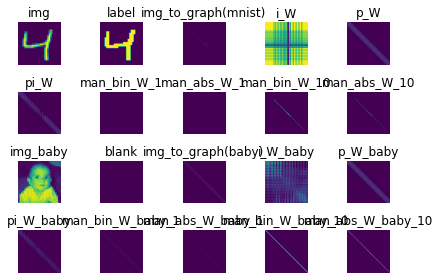

In [4]:
plt.rcParams["figure.figsize"] = (12,12) # specify the size for this cell
plot_images([img, labels, sk_W, i_W, p_W, pi_W, man_bin_W_1, man_abs_W_1, man_bin_W_10, man_abs_W_10,
             img_baby, np.zeros_like(img_baby), sk_W_baby, i_W_baby, p_W_baby, pi_W_baby, man_bin_W_baby_1, man_abs_W_baby_1, man_bin_W_baby_10, man_abs_W_baby_10], 
            
            ['img', 'label', 'img_to_graph(mnist)', 'i_W', 'p_W', 'pi_W', 'man_bin_W_1', 'man_abs_W_1', 'man_bin_W_10', 'man_abs_W_10',
             'img_baby', 'blank', 'img_to_graph(baby)', 'i_W_baby', 'p_W_baby', 'pi_W_baby', 'man_bin_W_baby_1', 'man_abs_W_baby_1', 'man_bin_W_baby_10', 'man_abs_W_baby_10'],
            colmns=5)

In [7]:
# to store multiple different methods
from collections import OrderedDict
from functools import partial

# the methods to store
import scipy.linalg as linalg
import scipy.sparse.linalg as sparse_linalg

# This initialization model has been chosen to be consistent with
# the ARPACK one as another initialization can lead to convergence issues.
# v0 = random_state.uniform(-1, 1, size)
# from https://github.com/scikit-learn/scikit-learn/blob/2a2772a87b6c772dc3b8292bcffb990ce27515a8/sklearn/utils/_arpack.py#L4

eigs_options = OrderedDict(
    
    # TODO: also check the spectrum of eigenvalues...
    # should be 0 to 2, which means shift invert by 1 for max 1.0 for faster compute
    
    
    np_eigh = np.linalg.eigh,
    
    eigh_base = partial(linalg.eigh),
    eigh_cff = partial(linalg.eigh, check_finite=False),
    # _, diffusion_map = eigh(laplacian, check_finite=False)
    # embedding = diffusion_map.T[:n_components]
    # from https://github.com/scikit-learn/scikit-learn/blob/2a2772a87b6c772dc3b8292bcffb990ce27515a8/sklearn/manifold/_spectral_embedding.py#L144
        
    # try for SM and SA, but if return eigenvectors True, should use SA anyway
    sparse_eigsh_1 = partial(sparse_linalg.eigsh, k=2, which='SA'),
    sparse_eigsh_2 = partial(sparse_linalg.eigsh, k=100, which='SM'),
    sparse_eigsh_3 = partial(sparse_linalg.eigsh, k=100, which='SM'),
    # sp_sparse_linalg.eigsh(A, which='SM', v0=v0, k=min(100, m - 2))
    
    
    # lobpcg(L, X, Y=Y, largest=False, tol=1e-3)
    # from bottom of https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.laplacian.html
    # where each thing is explained there..
)

In [8]:
# from time import time

# solve with any given eigensolver
def solve_here(W, solver):
    # Diagonal Matrix - D
    d = np.sum(W, axis=1)
    D = np.zeros_like(W)
    np.fill_diagonal(D, np.sum(W, axis=1))

    A = D - W
    # t0 = time()
    _, eig_vector = solver(A)
    # t = time() - t0
    op_image = eig_vector[:, 1].reshape(img.shape[0], img.shape[1]) # probably want to always double check this one is the second smallest??

    return op_image

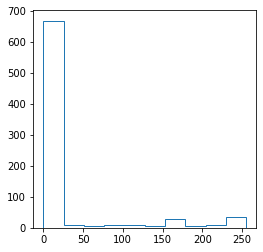

[669  10   7   9   8   5  27   5   8  36]
[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]


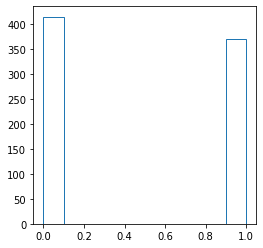

[414   0   0   0   0   0   0   0   0 370]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [9]:
counts, bins = np.histogram(img)
plt.stairs(counts,bins)
plt.show()
print(counts)
print(bins)

counts, bins = np.histogram(labels)
plt.stairs(counts,bins)
plt.show()
print(counts)
print(bins)